<a href="https://colab.research.google.com/github/mulliganaceous/2023_IonQ/blob/main/qaoa-for-max-cut/01_Max-Cut-with-QAOA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# SPDX-License-Identifier: Apache-2.0 AND CC-BY-NC-4.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Divide-and-Conquer Implementation of QAOA
## Lab 1 - Overview: Max cut with QAOA on a small graph
$
\renewcommand{\ket}[1]{|{#1}\rangle}
\renewcommand{\bra}[1]{\langle{#1}|}
$
This lab introduces the CUDA Quantum (CUDA-Q) platform through an example of a max cut problem solved with the QAOA (Quantum Approximate Optimization Algorithm). By the end of this lab, you will have reviewed the QAOA approach to a max cut problem, written quantum kernels with CUDA-Q, and simulated the QAOA for a max cut problem. Additionally, in preparation for Lab 2, you will have previewed the divide-and-conquer implementation of QAOA.  

We assume the reader has some familiarity already with quantum computation and is comfortable with the concepts of qubits, quantum circuits, measurement, Hamiltonians, expectation values, and circuit sampling. Comprehensive references include Nielsen and Chuang's [Quantum Computation and Quantum Information](https://michaelnielsen.org/qcqi/QINFO-book-nielsen-and-chuang-toc-and-chapter1-nov00.pdf), Aaronson's [Intro to Quantum Information Science lecture notes](https://scottaaronson.blog/?p=3943), and [Lecture notes from a Quantum Computing course](https://arxiv.org/pdf/2311.08445) taught at Chalmers University of Technology. Good video series are Nielsen's [Quantum Computing for the Determined](https://www.youtube.com/playlist?list=PL1826E60FD05B44E4) and Ekert's [Introduction to Quantum Information Science](https://youtu.be/feixH-rXPVs?feature=shared) which accompanies the work-in-progress [Introduction to Quantum Information Science ebook](https://qubit.guide).

The list below outlines what you'll be doing in each section of this lab:
* **1.1** Define the Max Cut problem
* **1.2** Experiment with a few NetworkX commands to visualize graphs
* **1.3** Identify a max cut solution of the `sampleGraph` through a classical brute-force computation
* **1.4** Review QAOA for Max Cut
* **1.5** Implement QAOA using CUDA-Q
* **1.6** Preview how to scale QAOA for larger graphs using divide-and-conquer QAOA

Learning Objectives:
* Apply CUDA-Q primitives such as `observe`, `sample`, and `vqe` to kernels
* Construct CUDA-Q kernels with and without parameters using function decoration
* Visualize the divide, conquer, and merge stage of the divide-and-conquer QAOA as it is applied to a small graph



In [1]:
# Instructions for Google Colab. You can ignore this cell if you have cuda-q set up.
# Run this notebook in a CPU runtime
# Uncomment the line below and execute the cell to install cuda-q
!pip install cudaq

!wget -q https://github.com/nvidia/cuda-q-academic/archive/refs/heads/main.zip
!unzip -q main.zip
!mv cuda-q-academic-main/qaoa-for-max-cut/images ./images

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.1/237.1 MB 5.1 MB/s eta 0:00:00
  Created wheel for cudaq: filename=cudaq-0.12.0.post1-py3-none-any.whl size=7140 sha256=c4511e6531a6d5c9a388b15e44ae77a1976dcbe8ca4a8ccea4a41c3a6aafc68f
  Stored in directory: /root/.cache/pip/wheels/28/46/73/06c85cbac5fac9d1aef5f8ffd2e96d1acda5bd101fdce3c0b9
Successfully built cudaq
  Attempting uninstall: cupy-cuda12x
    Found existing installation: cupy-cuda12x 13.6.0
    Uninstalling 

Execute the cells below to load all the necessary packages for this lab.

In [3]:
# install `qutip` and `ipywidgets` in the current Python kernel. Skip this if they are already installed.
# `matplotlib` is required for all visualization tasks.
# Make sure to restart your kernel if you execute this!
# In a Jupyter notebook, go to the menu bar > Kernel > Restart Kernel.
# In VSCode, click on the Restart button in the Jupyter toolbar.

# The '\' before the '>' operator is so that the shell does not misunderstand
# the '>' qualifier for the bash pipe operation.

import sys

try:
    import matplotlib.pyplot as plt
    import qutip
    import ipywidgets as widgets

except ImportError:
    print("Tools not found, installing. Please restart your kernel after this is done.")
    !{sys.executable} -m pip install qutip\>=5 matplotlib\>=3.5
    !{sys.executable} -m pip install ipywidgets
    print("\nNew libraries have been installed. Please restart your kernel!")

Tools not found, installing. Please restart your kernel after this is done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.6/31.6 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.3 MB/s eta 0:00:00

New libraries have been installed. Please restart your kernel!


In [4]:
# Necessary packages

import networkx as nx
from networkx import algorithms
from networkx.algorithms import community
import cudaq
from cudaq import spin
from cudaq.qis import *
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import ipywidgets as widgets
from ipywidgets import interact

## 1.1 Max Cut

If you prefer a video introduction to the material, please execute the cell below to view the video. Otherwise, feel free to skip to the next markdown block to read through the introduction to the max cut problem.

In [9]:
from IPython.display import HTML

video_url = "https://d36m44n9vdbmda.cloudfront.net/assets/x-ac-13-v1/max-cut-with-CUDA-Quantum-Lab-1-Part-1.mp4"

video_html = f"""
<video controls width="640" height="360">
    <source src="{video_url}" type="video/mp4">
    Your browser does not support the video tag.
</video>
"""

display(HTML(video_html))

[Max Cut](https://en.wikipedia.org/wiki/Maximum_cut) is the problem of finding a partition of a graph's nodes into two sets which maximizes the edges between the two sets. There is also a weighted version of this problem which we will explore in [Lab 4](4_Assessment.ipynb). Although this problem is relatively easy to solve for graphs with few vertices, this problem is [NP-hard](https://en.wikipedia.org/wiki/NP-hardness#:~:text=7%20References-,Definition,complete%20problem%20G%20to%20H.). The max cut problem has a wide range of applications including [machine learning](https://jmlr.org/papers/volume14/wang13a/wang13a.pdf), [circuit design](https://math.mit.edu/research/highschool/primes/materials/2020/Hong-Lee-Wei.pdf) and [statistical physics](https://www.researchgate.net/publication/262162554_An_Application_of_Combinatorial_Optimization_to_Statistical_Physics_and_Circuit_Layout_Design), among others. Furthermore, the QAOA algorithm presented in this tutorial can be adapted to other related optimization problems with an even wider application field including [portfolio optimization](https://journals.aps.org/prresearch/pdf/10.1103/PhysRevResearch.4.043204) and [job shop scheduling](https://www.sciencedirect.com/science/article/pii/S0377221723002072), just to name a few.

**Notation:** We take the convention that $G=(V,E)$ represents a graph with vertex set $V\subseteq \mathbb{N}$ and edge set $E\subseteq V\times V$. We use the terms vertex and node interchangeably.  For this tutorial we assume that the graphs are undirected (that is, $(u,v)$ and $(v,u)$ represent the same edge). Our graphs contain no self loops (i.e., for every vertex $v$, there is no edge $(v,v)$). A *cut* of the graph $G$ is a partition, $(V_0,V_1)$, of the vertex set such that every vertex of $V$ is a member of exactly one of $V_0$ or $V_1$ (i.e., $V_0\bigcup V_1 = V$ and $V_0\bigcap V_1=\emptyset$). The *cut value* for a partition is the sum of the edges with one node in $V_0$ and one node in $V_1$.

In the images below, we illustrate two cuts of a graph with the dotted lines. Each of these cuts partitions the graph into two disjoint sets. The cut on the left is not optimal, and the cut on the right is the max cut. The cut on the left divides the graph into disjoint sets $\{1,2\}$ and $\{0,3,4\}$, and that cut contains 3 edges. To more easily visualize the cut, we have colored the vertices in one set of the partition green and the vertices in the other set of the partition gray.
The cut depicted in the diagram on the right divides the graph vertices into two disjoint sets $V_0=\{0,2\}$, colored gray, and $V_1=\{1,3,4\}$, colored green. The number of edges connecting vertices in the distinct sets is computed by $$\sum_{\substack{u \in V_0; v\in V_1\\ (u,v) \in E}}1.$$ For the graph on the right, the number of edges in the cut (in this case there are $5$ edges) is maximal, and this value is referred to as the *max cut value*. The partitioning $(V_0,V_1)$  &mdash; and sometimes the set of edges connecting vertices in $V_0$ and $V_1$  &mdash; is referred to as a *max cut of a graph*. Note that the max cut of a graph need not be unique; that is, two distinct partitions may produce the same cut value.

![](https://github.com/NVIDIA/cuda-q-academic/blob/main/qaoa-for-max-cut/images/max-cut-illustration.png?raw=true)

Just as it was helpful for visualizing the partitions above, it will be helpful in this tutorial to view a solution of the max cut problem as a $2$-coloring (or a labeling) of the vertices of the graph where all nodes in $V_0$ are colored gray (or $0$) and all nodes in $V_1$ are colored green (or $1$).  Note that we make no requirements other than all nodes receive a color. In particular we do not require that adjacent vertices have distinct colors.  The coloring solely codes the partitioning of the set of vertices.

As we encode the max cut problem with CUDA-Q, we will eventually use bitstrings to represent the colors of the vertices in a cut. For example using the ordering of the vertices, the bitstring `01100` captures the partition in the image above on the left with vertices $1$ and $2$ in $V_1$, and the bitstring `01011` codes the partition in the image on the right with vertices $1$, $3$, and $4$ in $V_1$.


## 1.2 Defining a graph
For the remainder of this lab, we will work with the graph coded in the cell below and will refer to it as `sampleGraph`. We will be using the [NetworkX library](https://networkx.org/documentation/stable/tutorial.html) for the graphs in this tutorial. Please read through the cell below to familiarize yourself with some of the commands in the NetworkX library used in this tutorial.

The graph has 6 nodes and 7 edges.


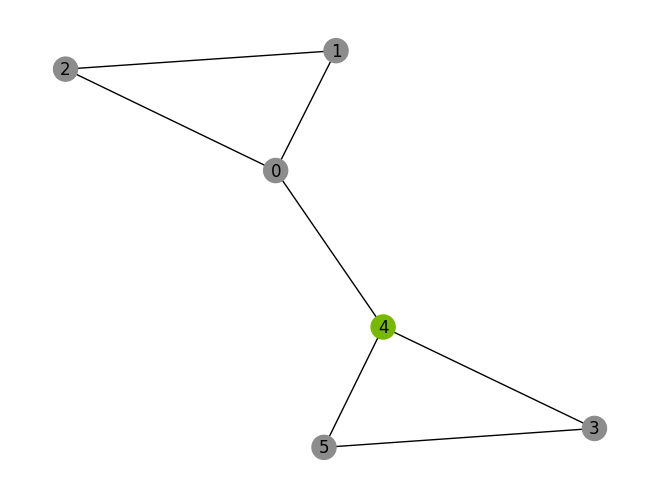

In [10]:
# Define a small graph that will be used throughout the Lab 1
# We'll refer to this graph as sampleGraph throughout the lab.
edgeList = [(0,1),(1,2),(2,0),(0,4),(4,5),(5,3),(4,3),(0,5),(2,5)]
sampleGraph =nx.from_edgelist(edgeList)

# We will be adding several attributes to our graph such as colors for the nodes
# and later in Lab 4, weights for the edges.
# This call sets the color of all nodes of the sampleGraph to 0:
nx.set_node_attributes(sampleGraph, values = 0, name = 'color')

# We can set or change node colors individually. For instance, let's change the
# color of the node 4 from 0 to 1:
sampleGraph.nodes[4]['color'] = 1

# These commands are helpful to list the nodes and edges of a graph and to compute the total
# number of vertices and edges of a graph. We separate out the edges of the graph into two
# lists (source and target) so that we can pass edges to the cudaq.kernels
node_List : List[int] = list(sampleGraph.nodes())
edges_in_graph = list(sampleGraph.edges()) #a list of ordered pairs of vertices representing the edges
print('The graph has',sampleGraph.number_of_nodes(),'nodes and', sampleGraph.number_of_edges(), 'edges.')

# Next for small graphs, it is sometimes helpful to visualize them and to color code the nodes.
# Set color codes for green and grey and assign gray to the nodes with color attribute 0
# and green to nodes with color attribute 1.
gray ='#8C8C8C'
green ='#76B900'
color_map = [gray if sampleGraph.nodes[u]['color']==0 else green for u in sampleGraph]

# Finally, we can plot the graph.
# Set the position of the nodes so that the graphs is easily recognizable each time it's plotted.
pos = nx.spring_layout(sampleGraph, seed=311)
# Plot the graph with nodes labeled with their name and colored gray for 0 and green for 1.
nx.draw(sampleGraph, with_labels=True, pos = pos, node_color=color_map)
plt.show()

Notice that the coloring above induces a cut with edges $(3,4)$, $(4,5)$, and $(0,4)$. This is not a maximal cut of this graph. The aim of this lab is to use QAOA to find a maximal cut.

In [7]:
# Since the coloring of the graph above was for demonstration purposes, we'll reset all the node
# colors to be 0 as a default. The only node color that needs to be reset is node 4.
sampleGraph.nodes[4]['color'] = 0

## 1.3 Classical solutions to Max Cut

For our small graph with seven vertices, there are only $2^7 = 128$ different choices of the partition sets $V_0$ and $V_1$. In fact, there are only $\frac{2^7}{2} = 64$ distinct partitions since the partition $V_0=W$, $V_1=V\backslash W$ is equivalent to the partition $V_0 = V\backslash W$, $V_1= W$ for any subset $W$ of $V$. Our graph is small enough that we can, by brute force, check every single partition to find the max cut.

Exercise:  Complete the code block below to find the max cut solution to the `sampleGraph` via brute-force computation. We won't worry about double checking the cut values of partitions $(W, V\backslash W)$ and $(V\backslash W, W)$. For this exercise, compute the cut values for each partition of vertices by replacing `FIX_ME` with selections of the following:
* `sampleGraph.nodes()`
* `sampleGraph.edges()`
* `subset_cut_value > max_cut_value`
* `u not in V0`

If you get stuck, you can click on the triple dots below to view the solution.

In [8]:
# Create a list of all the subsets of vertices of sampleGraph
subsets = [[]]
for u in FIX_ME: # Iterate through the vertices of the sampleGraph
    for i in range(len(subsets)):
        subsets += [subsets[i]+[u]]


# Cycle through the subsets and compute the cut value for each partition
# While doing these computations, identify the max cut of the sampleGraph by
# storing the best cut value and cut edges found so far and the corresponding subset
max_cut_value = 0
max_cut_edges = []
for subset in subsets:
    subset_cut_value = 0
    subset_cut_edges = []
    for u,v in FIX_ME: # the max cut depends only on pairs of vertices that are connected by an edge
        if ((u in subset) and (v not in subset)) or ((v in subset) and (u not in subset)):
            subset_cut_value+=1
            subset_cut_edges.append((u,v))
    if FIX_ME:
        max_cut_value = subset_cut_value
        max_cut_edges = subset_cut_edges
        V0 = subset # set corresponding to the best cut found so far


# Find the complement of V0
V1 = []
for FIX_ME:
    if FIX_ME:
        V1.append(u)

print('The',max_cut_value,'edges that make up a max cut of sampleGraph are',max_cut_edges)
print('The lists',V0,'and',V1,'partition the sampleGraph into a the max cut.' )

SyntaxError: invalid syntax (ipython-input-3084080044.py, line 28)

In [ ]:
# Solution

# Create a list of all the subsets of vertices of sampleGraph
subsets = [[]]
for u in sampleGraph.nodes():
    for i in range(len(subsets)):
        subsets += [subsets[i]+[u]]


# Cycle through the subsets to identify the max cut of the sampleGraph

max_cut_value = 0
max_cut_edges = []
for subset in subsets:
    subset_cut_value = 0
    subset_cut_edges = []
    for u,v in sampleGraph.edges():
        if ((u in subset) and (v not in subset)) or ((v in subset) and (u not in subset)):
            subset_cut_value+=1
            subset_cut_edges.append((u,v))
    if subset_cut_value > max_cut_value:
        max_cut_value = subset_cut_value
        max_cut_edges = subset_cut_edges
        V0 = subset


# Find the complement of V0
V1 = []
for u in sampleGraph.nodes():
    if u not in V0:
        V1.append(u)

print('The',max_cut_value,'edges that make up a max cut of sampleGraph are',max_cut_edges)
print('The lists',V0,'and',V1,'partition the sampleGraph into a the max cut.' )

## 1.4 Quantum Approximation Optimization Algorithm (QAOA) for Max Cut

In [ ]:
# Execute this cell to view a video presentation of section 1.4.1

from IPython.display import HTML

video_url = "https://d36m44n9vdbmda.cloudfront.net/assets/x-ac-13-v1/max-cut-with-CUDA-Quantum-Lab-1-Part-2.mp4"

video_html = f"""
<video controls width="640" height="360">
    <source src="{video_url}" type="video/mp4">
    Your browser does not support the video tag.
</video>
"""

display(HTML(video_html))

### 1.4.1 Quadratic Unconstrained Binary Optimization (QUBO) Formualtion of Max Cut
Since there are $2^{|V|}$ many distinct $2$-colorings of the graph, and $2^{|V|-1}$ distinct cuts of the graph, the brute-force approach to check every coloring of the graph is not scalable to large graphs.  There are several classical algorithms that perform better than the brute-force approach on certain subclasses of graphs, and there are heuristic algorithms that give good approximations to the max cut rather quickly. For a review of many of the classical approaches to max cut, check out [this paper](https://dl.acm.org/doi/full/10.1145/3609426?casa_token=ZrJI6LlgDHAAAAAA%3AhuO3qe07eG0kXdWEvKY4Xv7kIDpWXpe5SAr-zB9KVzOe3nHnTSE-zqqwbbhN_syDdfrASv8xGmv29sk) and [this one](https://optimization-online.org/wp-content/uploads/2015/05/4895.pdf). In this tutorial, we will be exploring a quantum heuristic algorithm for identifying good (but perhaps not maximal) cuts of graphs.  More specifically, we begin with QAOA (Quantum Approximate Optimization Algorithm) and then explore a [divide-and-conquer implementation of QAOA](https://arxiv.org/abs/2205.11762), which is one of [many adaptations of QAOA](https://arxiv.org/pdf/2306.09198.pdf).

In order to employ quantum algorithms, it is helpful to reframe the max cut problem as a quadratic unconstrained binary optimization (QUBO) problem.  Suppose that we have a graph $G=(V,E)$.  We can code a partition $(V_0, V_1)$ of $V$ by defining for each $v\in V$, a variable $x_v$ so that $x_v = 0$ if vertex $v\in V_0$ and $x_v =1 $ if $v\in V_1$. (Another way of thinking about this is that $x_v$ represents the coloring of a vertex $v$ as 0 or 1 depending on whether $v$ is a member of $V_0$ or $V_1$.)  The max cut problem then can be restated as finding an assignment to the variables $\bar{x} = [x_v\mid v\in V]$ so that the function $$C(\bar{x}) = \sum_{(u,v)\in E}(x_u+x_v-2x_u x_v)$$ is maximized.  

Let's walk through the formula above to observe that $C(\bar{x})$ computes the cut value of the graph for the partition coded by $\bar{x}$. For example, notice that if $(u,v)$ were an edge and we assigned $0$ to $x_u $ and $1$ to $x_v$, this edge would be in the cut given by the partition. Furthermore, the value of the term ($x_u+x_v-2x_ux_v$) associated with this edge in the equation $C(\bar{x})$ would be $0+1-2*0*1 = 1$.  Take a minute to consider what happens to the term associated with $(u,v)$ in the equation for $C(\bar{x})$ if $x_u$ and $x_v$ were both assigned 1 (and therefore, the edge between them would not be in the cut). Is the result what you expected?

QUBO problems have a natural translation to Ising Hamilitonian problems (see for instance [this article](https://arxiv.org/pdf/1811.11538.pdf)). This translation is carried out by mapping the binary $(0,1)$-variables $x_v$ to variables $z_v$ that take on the values $-1$ and $1$. Take a moment to verify that by assigning $-1$ and $1$ to identify a cut of a graph, the equation below computes the cut value for that cut: $$C(\bar z) = \frac{1}{2} \sum_{(u,v)\in E} (1-z_uz_v).$$ Take for instance an edge $(u,v)$ with the assignments $z_u=z_v=1$. This edge would not be in the cut determined by these variable assignments.  The term in the equation above associated with this edge would be $\frac{1}{2}(1-z_uz_v) = \frac{1}{2}(1-1*1) = 0$ and would not contribute to the cut edge count.  Verify that the assignment $z_u=1$ and $z_v=-1$ and the assignment $z_u=z_v=-1$ both produce the result you would expect for $C(\bar z)$ to compute the cut value.

Notice that if we multiply $C(\bar z)$ by -1, we can reframe the optimization problem from maximization to minimization.  Furthermore, we can promote this equation to a matrix equation by replacing $z_uz_v-1$ with the Pauli-Z operator acting on qubits associated with nodes $u$ and $v$, respectively, and replacing 1 with the identity matrix. This leads to the reformulation of the problem from one of maximizing $C(\bar{z})$ to one of minimizing the eigenvalues of $$H= \frac{1}{2}\sum_{(u,v)\in E} (Z_uZ_v-II).$$  




### 1.4.2 QAOA


In [ ]:
# Execute this cell to watch an overview of QAOA.
from IPython.display import HTML

video_url = "https://d36m44n9vdbmda.cloudfront.net/assets/x-ac-13-v1/max-cut-with-CUDA-Quantum-Lab-1-Part-3.mp4"

video_html = f"""
<video controls width="640" height="360">
    <source src="{video_url}" type="video/mp4">
    Your browser does not support the video tag.
</video>
"""

display(HTML(video_html))

In this section, we will describe the Quantum Approximate Optimization Algorithm (QAOA) for solving the Max Cut problem. [Farhi et al.](https://arxiv.org/pdf/1411.4028) (2014) originally introduced QAOA to tackle optimization problems like Max Cut. More recent research by [Farhi et al.](https://arxiv.org/pdf/2503.12789) (2025) have shown that QAOA can establish lower bounds on the maximum cut achievable in high girth 3-regular graphs, surpassing previously known bounds. This study indicates that QAOA can guarantee the existence of such cuts through classical numerical analysis, suggesting an exponential speedup over the best known classical algorithms for finding cuts of this size on graphs of this girth.

In essence, QAOA is a variational algorithm composed of a variational quantum circuit (a kernel dependent on a set of parameter values) and a classical optimizer. The goal of QAOA is to use the classical optimizer to identify parameter values that generate a quantum circuit whose expectation value for a given cost Hamiltonian is minimized. In our case, the cost Hamiltonian will be as defined in the previous section.

The diagram below depicts the subroutines in QAOA.

![](https://github.com/NVIDIA/cuda-q-academic/blob/main/qaoa-for-max-cut/images/QAOA-flowchart.png?raw=true)

The two green process blocks in the image above represent the quantum subroutines that we'll execute with CUDA-Q primitives. The green process block on the left will use the `observe` primitive to estimate the expectation value (this primitive is subsumed in a `vqe` call) and the green process on the right will use the `sample` primitive to identify the most probable outcome of the circuit. We'll describe how to program this entire flowchart using CUDA-Q in the following sections.


## 1.5 CUDA-Q Implementation of QAOA for Max Cut

This section starts with a brief review of CUDA-Q syntax. From there, we can define a function to carry out QAOA by creating several helper functions for the problem Hamiltonian, QAOA kernel, etc. If you'd like to treat the QAOA algorithm as a black box, you can jump to section 1.5.6 where we pull everything together and demonstrate how to simulate the kernel on a GPU. However, understanding the code below is necessary for the remainder of the labs.

### 1.5.1 CUDA-Q Basics

Before implementing QAOA in CUDA-Q, let's run through [two quick examples](https://nvidia.github.io/cuda-quantum/latest/using/basics/build_kernel.html) highlighting most of the syntax that we will need.  The first thing to note is that we will sometimes refer to quantum circuits as kernels.  While every quantum circuit is a kernel, kernels need not be quantum circuits. CUDA-Q kernels allow for the creation of generic quantum programs that can be compiled and executed on various devices. They provide better interplatform compatability and control flow. We will see some more general quantum kernels towards the end of this lab, but for now you can think of a kernel as a quantum circuit.

There are two main primitives common in most quantum algorithms: sampling a circuit to approximate the probability distribution of the state and computing expectation values given a circuit and Hamiltonian. As an introduction to CUDA-Q, we provide two short examples of these routines below.

The first example in the code block below demonstrates how to
1. select a backend for kernel execution or simulation
2. define the kernel which involves initializing the quantum kernel and allocating qubits, applying gates to the kernel (in this case we'll create a 2-qubit [GHZ state](https://en.wikipedia.org/wiki/Greenberger–Horne–Zeilinger_state)), and measuring the state
3. sample the outcomes.

We will be using CPUs to simulate quantum kernels throughout this tutorial. In other notebooks, we'll discuss how to change the target to access GPUs. While it is easy to switch to a quantum processor, by simply changing the target (refer to [this guide](https://nvidia.github.io/cuda-quantum/latest/using/hardware.html) for more details), there are some differences between how the code is implemented behind the scenes. In simulation mode, the quantum state is built once and then sampled `shots_count` many times. In quantum hardware execution mode, the quantum state collapses upon measurement and hence needs to be rebuilt over and over again.

For the example below, we expect to see about 50% of the outcomes to be the `00` state and about 50% to be in the `11` state.  

In [ ]:
# Example 1


##############################################################
#  1. Select a backend for kernel execution
cudaq.set_target("qpp-cpu")
##############################################################

##############################################################
# 2. Define a kernel function
@cudaq.kernel
def kernel(qubit_count: int):
    # Allocate our `qubit_count` to the kernel.
    qvector = cudaq.qvector(qubit_count)

    # Apply a Hadamard gate to the qubit indexed by 0.
    h(qvector[0])
    # Apply a Controlled-X gate between qubit 0 (acting as the control)
    # and each of the remaining qubits.
    for i in range(1, qubit_count):
        x.ctrl(qvector[0], qvector[i])

    # Measure the qubits
    # If we don't specify measurements, all qubits are measured in
    # the Z-basis by default.
    mz(qvector)

##############################################################
# 3. Call the kernel function with the variable qubit_count set to 2 and sample the outcomes
qubit_count = 2
result = cudaq.sample(kernel, qubit_count, shots_count=1000)

print(result)

The next example shows how to use CUDA-Q to compute the expectation value $\langle \psi |H|\psi\rangle$, where $H$ is a Hamiltonian and $|\psi\rangle$ is a quantum state defined by the kernel. We'll use the GHZ state, $|\psi\rangle = \frac{1}{\sqrt{2}}|00\rangle+|11\rangle$. Therefore, our kernel will be the same as the previous example, but we will remove the measurement. The Hamiltonian $H = ZI + 2IY - XZ$ is encoded using the `spin` operators in `cudaq` and they can be combined together with scalers using `+` and `*`. The `observe` primitive computes many statistics, but we will only need the `.expectation()` value.

In [ ]:
# Example 2
qubit_count = 2

# Define a quantum kernel function.
@cudaq.kernel
def kernel(qubit_count: int):
    # Allocate our `qubit_count` to the kernel.
    qvector = cudaq.qvector(qubit_count)

    # Apply a Hadamard gate to the qubit indexed by 0.
    h(qvector[0])
    # Apply a Controlled-X gate between qubit 0 (acting as the control)
    # and each of the remaining qubits.
    for i in range(1, qubit_count):
        x.ctrl(qvector[0], qvector[i])


# Define a Hamiltonian in terms of Pauli Spin operators.
hamiltonian = spin.z(0) + 2*spin.y(1) - spin.x(0) * spin.z(1)

# Compute the expectation value given the state prepared by the kernel.
result = cudaq.observe(kernel, hamiltonian, qubit_count, shots_count = 1000).expectation()

print('<psi|H|psi> =', result)

### 1.5.2 Problem Hamiltonian

**Exercise:** Using the syntax demonstrated in the previous section, edit the line commented as `###FIX_ME###` in the code block below to define the problem Hamiltonian.  Recall that for max cut problems, the problem Hamiltonian is $$H= \frac{1}{2}\sum_{(u,v)\in E} (Z_uZ_v-II),$$ where $E$ is the set of edges in our graph and $Z_u$ is shorthand for the spin $Z$ operator applied to the qubit associated with vertex $u$. In a similar manner $II$ can be thought of as $I_uI_v$. Hint: you will need to use the `spin.z` and `spin.i` operations. Click on the triple dots in the 2nd cell below to view the solution.

In [ ]:
# Define a function to generate the Hamiltonian for a max cut problem using the graph G

def hamiltonian_max_cut(sources : List[int], targets : List[int]):
    """Hamiltonian for finding the max cut for the graph  with edges defined by the pairs generated by source and target edges

    Parameters
    ----------
    sources: List[int]
        list of the source vertices for edges in the graph
    targets: List[int]
        list of the target vertices for the edges in the graph

    Returns
    -------
    cudaq.SpinOperator
        Hamiltonian for finding the max cut of the graph defined by the given edges
    """
    hamiltonian = 0
    # Since our vertices may not be a list from 0 to n, or may not even be integers,

    for i in range(len(sources)):
        # Add a term to the Hamiltonian for the edge (u,v)
        qubitu = sources[i]
        qubitv = targets[i]
        hamiltonian += spin.z(qubitu) ######FIX_ME

    return hamiltonian

In [ ]:
# SOLUTION

# Define a function to generate the Hamiltonian for a max cut problem using the graph G

def hamiltonian_max_cut(sources : List[int], targets : List[int]):
    """Hamiltonian for finding the max cut for the graph  with edges defined by the pairs generated by source and target edges

    Parameters
    ----------
    sources: List[int]
        list of the source vertices for edges in the graph
    targets: List[int]
        list of the target vertices for the edges in the graph

    Returns
    -------
    cudaq.SpinOperator
        Hamiltonian for finding the max cut of the graph defined by the given edges
    """
    hamiltonian = 0
    # Since our vertices may not be a list from 0 to n, or may not even be integers,

    for i in range(len(sources)):
        # Add a term to the Hamiltonian for the edge (u,v)
        qubitu = sources[i]
        qubitv = targets[i]
        hamiltonian += 0.5*(spin.z(qubitu)*spin.z(qubitv)-spin.i(qubitu)*spin.i(qubitv))

    return hamiltonian


### 1.5.3 QAOA Circuit

In order to program QAOA for our max cut problem, we need to understand the structure of the variational QAOA quantum circuit. The general structure of the circuit is described and depicted below:
* For each vertex in the graph, there is an associated qubit in the circuit.
* The circuit is initialized in a superposition state, corresponding to a a state in which each possible coloring of vertices of the graph is equally likely. This is achieved with the Hadamard gates on the left of the diagram.
* The QAOA circuit is made up of repeated blocks (referred to as layers) of a problem kernel and a mixer kernel. These layers are outlined in light gray.
    * The problem kernel is drawn in blue. It encodes our graph. We'll go into more details about the make up of the problem kernel later in this section.
    * The mixer kernel is composed of the green parameterized rotation gates in the diagram below.

![](https://github.com/NVIDIA/cuda-q-academic/blob/main/qaoa-for-max-cut/images/qaoa-circuit-layers.png?raw=true)

Let's take a closer look at the problem kernel, which encodes the structure of the graph for the max cut problem.  For each edge $(u,v)$ in the `sampleGraph` a contolled-$X$ gate is applied with control qubit associated with $u$ and target qubit associated with $v$.  Then a parameterized $Z$-rotation is applied to the qubit associated with $v$, and this is followed by another controlled-$X$ gate identical to the first one applied. The diagram below illustrates how the edge between node 1 and 2 in the graph drawn below would get encoded in the kernel. Here we have assigned vertex 1 to qubit 1 and vertex 2 to qubit 2. The encoding of edges is repeated for each edge of the graph. Within a given layer of the QAOA cicuit, the same parameter is used for all of the edge encodings in the problem kernel, but new parameters are introduced for each layer.

![](https://github.com/NVIDIA/cuda-q-academic/blob/main/qaoa-for-max-cut/images/qaoa-problem-kernel.png?raw=true)

In the code block below, edit the FIX_ME commands to define a kernel function that takes as input 2 qubits corresponding to an edge in our graph and a parameter, then applies the parameterized-gate sequence depicted in the image above to those two qubits.  

In [ ]:
# Problem Kernel

@cudaq.kernel
def qaoaProblem(qubit_0 : cudaq.qubit, qubit_1 : cudaq.qubit, alpha : float):
    """Build the QAOA gate sequence between two qubits that represent an edge of the graph
    Parameters
    ----------
    qubit_0: cudaq.qubit
        Qubit representing the first vertex of an edge
    qubit_1: cudaq.qubit
        Qubit representing the second vertex of an edge
    alpha: List[float]
        Free variable


    """
    FIX_ME(qubit_0, qubit_1)
    rz(2.0*alpha, qubit_1)
    FIX_ME(qubit_0, qubit_1)

In [ ]:
# SOLUTION
# Problem Kernel

@cudaq.kernel
def qaoaProblem(qubit_0 : cudaq.qubit, qubit_1 : cudaq.qubit, alpha : float):
    """Build the QAOA gate sequence between two qubits that represent an edge of the graph
    Parameters
    ----------
    qubit_0: cudaq.qubit
        Qubit representing the first vertex of an edge
    qubit_1: cudaq.qubit
        Qubit representing the second vertex of an edge
    alpha: float
        Free variable


    """
    x.ctrl(qubit_0, qubit_1)
    rz(2.0*alpha, qubit_1)
    x.ctrl(qubit_0, qubit_1)

Now, we'll create a kernel function for the mixer.  This kernel will take as input a qubit and a parameter, and applies a parameterized x-rotation gate to the qubit.  Edit FIX_ME statements in the code block below.

In [ ]:
# Mixer Kernel

@cudaq.kernel
def qaoaMixer(FIX_ME):
    """Build the QAOA gate sequence that is applied to each qubit in the mixer portion of the circuit
    Parameters
    ----------
    qubit_0: cudaq.qubit
        Qubit
    beta: float
        Free variable


    """
    rx(2.0*beta, FIX_ME)


In [ ]:
# SOLUTION
# Mixer Kernel

@cudaq.kernel
def qaoaMixer(qubit_0 : cudaq.qubit, beta : float):
    """Build the QAOA gate sequence that is applied to each qubit in the mixer portion of the circuit
    Parameters
    ----------
    qubit_0: cudaq.qubit
        Qubit
    beta: float
        Free variable


    """
    rx(2.0*beta, qubit_0)


We're ready to put these kernels together to build up the QAOA circuit. You are tasked in the exercise below to edit the FIX_MEs to carry out the first steps:  
* initialize the qubits - one for each vertex in our graph
* place the qubits in superposition.

Then, the two kernels that we created in the previous blocks will be added to form the layers in the QAOA circuit.  

In [ ]:
# We now define the kernel_qaoa function which will be the QAOA circuit for our graph
# Since the QAOA circuit for max cut depends on the structure of the graph,
# we'll feed in global concrete variable values into the kernel_qaoa function for the qubit_count, layer_count, edges_src, edges_tgt.
# The types for these variables are restricted to Quake Values (e.g. qubit, int, List[int], ...)
# The thetas plaeholder will be our free parameters (the alphas and betas in the circuit diagrams depicted above)
@cudaq.kernel
def kernel_qaoa(qubit_count :int, layer_count: int, edges_src: List[int], edges_tgt: List[int], thetas : List[float]):
    """Build the QAOA circuit for max cut of the graph with given edges and nodes
    Parameters
    ----------
    qubit_count: int
        Number of qubits in the circuit, which is the same as the number of nodes in our graph
    layer_count : int
        Number of layers in the QAOA kernel
    edges_src: List[int]
        List of the first (source) node listed in each edge of the graph, when the edges of the graph are listed as pairs of nodes
    edges_tgt: List[int]
        List of the second (target) node listed in each edge of the graph, when the edges of the graph are listed as pairs of nodes
    thetas: List[float]
        Free variables to be optimized


    """
    # Let's allocate the qubits
    qreg = cudaq.qvector(FIX_ME)

    # And then place the qubits in superposition
    h(FIX_ME)

    # Each layer has two components: the problem kernel and the mixer
    for i in range(layer_count):
        # Add the problem kernel to each layer
        for edge in range(len(edges_src)):
            qubitu = edges_src[edge]
            qubitv = edges_tgt[edge]
            qaoaProblem(qreg[qubitu], qreg[qubitv], thetas[i])
        # Add the mixer kernel to each layer
        for j in range(qubit_count):
            qaoaMixer(qreg[j],thetas[i+layer_count])

In [ ]:
# SOLUTION

# We now define the kernel_qaoa function which will be the QAOA circuit for our graph
# Since the QAOA circuit for max cut depends on the structure of the graph,
# we'll feed in global concrete variable values into the kernel_qaoa function for the qubit_count, layer_count, edges_src, edges_tgt.
# The types for these variables are restricted to Quake Values (e.g. qubit, int, List[int], ...)
# The thetas plaeholder will be our free parameters (the alphas and betas in the circuit diagrams depicted above)
@cudaq.kernel
def kernel_qaoa(qubit_count :int, layer_count: int, edges_src: List[int], edges_tgt: List[int], thetas : List[float]):
    """Build the QAOA circuit for max cut of the graph with given edges and nodes
    Parameters
    ----------
    qubit_count: int
        Number of qubits in the circuit, which is the same as the number of nodes in our graph
    layer_count : int
        Number of layers in the QAOA kernel
    edges_src: List[int]
        List of the first (source) node listed in each edge of the graph, when the edges of the graph are listed as pairs of nodes
    edges_tgt: List[int]
        List of the second (target) node listed in each edge of the graph, when the edges of the graph are listed as pairs of nodes
    thetas: List[float]
        Free variables to be optimized

    """
    # Let's allocate the qubits
    qreg = cudaq.qvector(qubit_count)

    # And then place the qubits in superposition
    h(qreg)

    # Each layer has two components: the problem kernel and the mixer
    for i in range(layer_count):
        # Add the problem kernel to each layer
        for edge in range(len(edges_src)):
            qubitu = edges_src[edge]
            qubitv = edges_tgt[edge]
            qaoaProblem(qreg[qubitu], qreg[qubitv], thetas[i])
        # Add the mixer kernel to each layer
        for j in range(qubit_count):
            qaoaMixer(qreg[j],thetas[i+layer_count])

**Side Note:**  In this tutorial we defined kernels using the preferred [`PyKernel` decorator](https://nvidia.github.io/cuda-quantum/latest/api/languages/python_api.html#cudaq.PyKernel). An alternative method for defining kerels is to use the
 [kernel builder](https://nvidia.github.io/cuda-quantum/latest/api/languages/python_api.html#cudaq.make_kernel) syntax.

That completes the QAOA kernel. Before moving on to define the optimizer, let's examine how varying parameter values produce different graph colorings with corresponding cut values when executing the QAOA circuit. Execute the cell below to generate a widget. You don't need to worry about the code in that cell, just focus on the widget. In the widget, adjust the sliders to experiment with different parameter values and visualize the resulting graph coloring from the QAOA circuit's execution.  

In [ ]:
# Execute this cell to generate a widget to visualize the effect of changing the parameters

# Set variables
seed = 123
cudaq.set_random_seed(seed)
shots = 1
layer_count = 1
parameter_count = 2 * layer_count  # Each layer of the QAOA kernel contains 2 parameters
%matplotlib inline
# Problem parameters from the graph
nodes = list(sampleGraph.nodes())
qubit_count = len(nodes)  # The number of qubits we'll need is the same as the number of vertices in our graph
qubit_src = []
qubit_tgt = []
for u, v in nx.edges(sampleGraph):
    qubit_src.append(nodes.index(u))
    qubit_tgt.append(nodes.index(v))

# Function to update the graph based on parameter values
def update_graph(param1, param2):
    initial_parameters = [param1, param2]

    # Sample the circuit using the initial parameters
    counts = cudaq.sample(kernel_qaoa, qubit_count, layer_count, qubit_src, qubit_tgt, initial_parameters, shots_count=shots)
    #result = str(counts)
    result = str(counts.most_probable())

    # Map the resulting bitstring from the qubit measurements to a list of integer values
    graphColors = [int(i) for i in result]
    nodes_sorted = sorted(list(nx.nodes(sampleGraph)))

    # Compute the cut value associated with resulting coloring
    sampleGraphMaxCut = 0
    cut_edges = []
    for u, v in sampleGraph.edges():
        indexu = nodes_sorted.index(u)
        indexv = nodes_sorted.index(v)
        if graphColors[indexu] != graphColors[indexv]:
            sampleGraphMaxCut += 1
            cut_edges.append((u, v))

    # Compute the partitioning associated with resulting coloring
    cut0 = []
    cut1 = []
    for u in sampleGraph.nodes():
        indexu = nodes_sorted.index(u)
        if graphColors[indexu] == 0:
            cut0.append(u)
            sampleGraph.nodes[u]['color'] = 0
        else:
            cut1.append(u)
            sampleGraph.nodes[u]['color'] = 1



    # Draw the graph identifying the max cut
    max_cut_color_map = ['#8C8C8C' if sampleGraph.nodes[u]['color'] == 0 else '#76B900' for u in sampleGraph]

    plt.figure(figsize=(8, 6))
    nx.draw_networkx_edges(
        sampleGraph,
        pos,
        edgelist=cut_edges,
        width=8,
        alpha=0.5,
        edge_color='#76B900',
    )
    nx.draw(sampleGraph, with_labels=True, pos=pos, node_color=max_cut_color_map)
    plt.show()
    print('The cut found using the parameters α1 and β1 in the QAOA circuit is highlighted in green.')
    print('The cut value for the this coloring is', sampleGraphMaxCut)

# Create sliders for the initial parameters
param1_slider = widgets.FloatSlider(min=-np.pi, max=np.pi, step=0.1, value=np.random.uniform(-np.pi, np.pi), description='α1')
param2_slider = widgets.FloatSlider(min=-np.pi, max=np.pi, step=0.1, value=np.random.uniform(-np.pi, np.pi),description='β1')

# Create the interactive widget
interact(update_graph, param1=param1_slider, param2=param2_slider)

As you may notice, some parameter values yield better cuts than others. This is where the classical optimizer loop comes into play. Each iteration of the loop suggests a new set of parameters to improve the cut, aiming to converge on the maximum cut of the graph.  We'll define the optimizer loop next.


### 1.5.4 Optimizer Loop

CUDA-Q has several built-in optimizers. You can find more information about the optimizers [here](https://nvidia.github.io/cuda-quantum/latest/api/languages/python_api.html#optimizers).  

The code block below defines our optimizer and sets the initial parameter values. We'll use the COBYLA optimizer.  We'll set a seed and choose initial parameter values randomly. Recall that the number of parameters needed depends on the number of layers in our QAOA circuit.  Each layer calls two parameters, one for the problem kernel and one for the mixer.

In [ ]:
# Define the optimizer
seed = 110
layer_count = 1 # set arbitrarily
parameter_count: int = 2 * layer_count

# Specify the optimizer and its initial parameters.
optimizer = cudaq.optimizers.COBYLA()
np.random.seed(seed)
optimizer.initial_parameters = np.random.uniform(-np.pi, np.pi,
                                                     parameter_count)


The `vqe` function is built into CUDA-Q and carries out the optimization loop once the optimizer, initial parameters, kernel, and Hamiltonian cost function have been defined. Let's add the `vqe` call to the code. The code block below implements the full optimizer loop. When you execute the code, you'll see the optimal parameter values identified for the max cut approximate solution to our `sampleGraph`.  In the next two sections, we'll walk through how to read out an optimal cut from this.

In [ ]:
# Define the optimizer

# Problem parameters
seed = 110
qubit_count = len(node_List) # The number of qubits we'll need is the same as the number of vertices in our graph
layer_count = 1 # set arbitrarily
parameter_count: int = 2 * layer_count   # Each layer of the QAOA kernel contains 2 parameters
nodes = sorted(list(nx.nodes(sampleGraph)))
# In the event our nodes aren't listed as consecutive integers starting with 0, we will map them to qubits
edge_qubit_src = []
edge_qubit_tgt = []
for u, v in nx.edges(sampleGraph):
    # We can use the index() command to read out the qubits associated with the vertex u and v.
    edge_qubit_src.append(nodes.index(u))
    edge_qubit_tgt.append(nodes.index(v))


# Specify the optimizer and its initial parameters.
optimizer = cudaq.optimizers.COBYLA()
np.random.seed(seed)
optimizer.initial_parameters = np.random.uniform(-np.pi, np.pi,
                                                     parameter_count)

# Pass the kernel, spin operator, and optimizer to `cudaq.vqe`.
optimal_expectation, optimal_parameters = cudaq.vqe(
    kernel=kernel_qaoa,
    spin_operator=hamiltonian_max_cut(edge_qubit_src,edge_qubit_tgt),
    argument_mapper=lambda parameter_vector: (qubit_count, layer_count, edge_qubit_src, edge_qubit_tgt, parameter_vector),
    optimizer=optimizer,
    parameter_count=parameter_count)

# Print the optimized value and its parameters
print("Optimal value = ", optimal_expectation)
print("Optimal parameters = ", optimal_parameters)

We can read out an approximation for the max cut value from this result.  The optimal value reported is the average value ($\langle \psi|H|\psi\rangle$) of our problem Hamiltonian $H$ when applied to the state generated by the quantum circuit with the optimal parameter values.  What this means that at our max cut value for the `sampleGraph` is at least 4.466. We'll use the sampling in the next section to identify the most probable measurements of the state generated by the QAOA kernel with these optimal parameter values.

Since we'll eventually be applying QAOA to several graphs, let's wrap all of this into a function that takes as input the graph, layer count, and seed and outputs the optimal parameters found after executing QAOA with the given layer count and seed for max cut on the given graph. We'll want to apply QAOA to graphs whose vertices may not be indexed by consecutive integers ranging from 0 to n, so we'll need to do some bookkeeping before passing the graph to the QAOA kernel by identifying the each vertex with its position in a sorted list of the vertices of the graph.

In [ ]:
def find_optimal_parameters(G, layer_count, seed):
    """Function for finding the optimal parameters of QAOA for the max cut of a graph

    Parameters
    ----------
    G: networkX graph
        Problem graph whose max cut we aim to find
    layer_count : int
        Number of layers in the QAOA circuit
    seed : int
        Random seed for reproducibility of results

    Returns
    -------
    list[float]
        Optimal parameters for the QAOA applied to the given graph G
    """
    parameter_count: int = 2 * layer_count

    # Problem parameters
    nodes = sorted(list(nx.nodes(G)))
    qubit_src = []
    qubit_tgt = []
    for u, v in nx.edges(G):
        # We can use the index() command to read out the qubits associated with the vertex u and v.
        qubit_src.append(nodes.index(u))
        qubit_tgt.append(nodes.index(v))
    # The number of qubits we'll need is the same as the number of vertices in our graph
    qubit_count : int = len(nodes)
    # Each layer of the QAOA kernel contains 2 parameters
    parameter_count : int = 2*layer_count

    # Specify the optimizer and its initial parameters.
    optimizer = cudaq.optimizers.COBYLA()
    np.random.seed(seed)
    optimizer.initial_parameters = np.random.uniform(-np.pi, np.pi,
                                                     parameter_count)

    # Pass the kernel, spin operator, and optimizer to `cudaq.vqe`.
    optimal_expectation, optimal_parameters = cudaq.vqe(
        kernel=kernel_qaoa,
        spin_operator=hamiltonian_max_cut(qubit_src, qubit_tgt),
        argument_mapper=lambda parameter_vector: (qubit_count, layer_count, qubit_src, qubit_tgt, parameter_vector),
        optimizer=optimizer,
        parameter_count=parameter_count)

    return optimal_parameters

Let's verify that the `find_optimal_parameters` function executes as expected.

In [ ]:
# Testing the find_optimal_parameters function
layer_count =1
seed = 110

find_optimal_parameters(sampleGraph, layer_count, seed)


### 1.5.5 Sampling the results of QAOA

The final step of the QAOA is to sample the QAOA circuit using the optimal parameters identified through the optimization loop.  This is carried out with `sample` for which we can specify the number of shots.  The code block below adds the sampling instruction. For now, we'll set the `layer_count` to be 1. Notice that there are $2^7=128$ many colorings of the 7 nodes.  Therefore, we want to make sure that our `shots_count` will be large enough to distinguish the most probable outcome among these 128 states.

In [ ]:
# Sampling the results of QAOA
# QAOA and sampling parameters
cudaq.set_random_seed(seed)
shots = 5000
layer_count = 1
parameter_count : int = 2*layer_count # Each layer of the QAOA kernel contains 2 parameters

# Problem parameters from the graph
nodes = list(sampleGraph.nodes())
qubit_count : int = len(nodes) # The number of qubits we'll need is the same as the number of vertices in our graph
qubit_src = []
qubit_tgt = []
for u, v in nx.edges(sampleGraph):
    # We can use the index() command to read out the qubits associated with the vertex u and v.
    qubit_src.append(nodes.index(u))
    qubit_tgt.append(nodes.index(v))


# retrieve optimal parameters from running VQE through the find_optimal_parameters function
optimal_parameters = find_optimal_parameters(G = sampleGraph, layer_count = layer_count, seed = 123)

# Sample the circuit using the optimized parameters
# The structure of the sample call is sample(kernel, *args, shots_count=1000, noise_model=None) where *args are the
# concrete values for evaluating the kernel function
counts = cudaq.sample(kernel_qaoa, qubit_count, layer_count, qubit_src, qubit_tgt, optimal_parameters, shots_count=shots)
print('most_probable outcome = ',counts.most_probable())
results = str(counts.most_probable())


### 1.5.6 Creating a function to carry out QAOA for max cut on a graph


Because we'll want to reuse this code later on and apply the QAOA algorithm to other graphs, we'll create a function that carries out QAOA for max cut on a given graph with specified layer count, number of shots in the sampling subroutine, and a random seed for reproducibility.

In [ ]:
def qaoa_for_graph(G, layer_count, shots, seed):
    """Function for finding the max cut of a graph using QAOA

    Parameters
    ----------
    G: networkX graph
        Problem graph whose max cut we aim to find
    layer_count : int
        Number of layers in the QAOA circuit
    shots : int
        Number of shots in the sampling subroutine
    seed : int
        Random seed for reproducibility of results

    Returns
    -------
    str
        Binary string representing the max cut coloring of the vertinces of the graph
    """


    parameter_count: int = 2 * layer_count

    # Problem parameters
    nodes = sorted(list(nx.nodes(G)))
    qubit_src = []
    qubit_tgt = []
    for u, v in nx.edges(G):
        # We can use the index() command to read out the qubits associated with the vertex u and v.
        qubit_src.append(nodes.index(u))
        qubit_tgt.append(nodes.index(v))
    # The number of qubits we'll need is the same as the number of vertices in our graph
    qubit_count : int = len(nodes)
    # Each layer of the QAOA kernel contains 2 parameters
    parameter_count : int = 2*layer_count

    optimal_parameters = find_optimal_parameters(sampleGraph, layer_count, seed)

    # Print the optimized parameters
    print("Optimal parameters = ", optimal_parameters)

    # Sample the circuit
    counts = cudaq.sample(kernel_qaoa, qubit_count, layer_count, qubit_src, qubit_tgt, optimal_parameters, shots_count=shots)
    print('most_probable outcome = ',counts.most_probable())
    results = str(counts.most_probable())
    return results

We are ready to run our code to find the max cut of `sampleGraph`! Execute the code block below which calls on the `qaoa_for_graph` function that we've defined in the previous sections, interprets the resulting bitstring as a coloring or partitioning of sample graph, and computes the cut.

In [ ]:
# Apply the QAOA algorithm to the sampleGraph max cut problem using
# seed = 110
result = qaoa_for_graph(sampleGraph, 1, 5000, 110)

# Map the resulting bitstring from the qubit measurements
# to a list of integer values in the same order as the nodes
# to determine a coloring of the vertices
graphColors=[int(i) for i in result]
nodes = sorted(list(nx.nodes(sampleGraph)))

# compute the cut value associated with resulting coloring
sampleGraphMaxCut =0
cut_edges = []
for u, v in sampleGraph.edges():
    indexu = nodes.index(u)
    indexv = nodes.index(v)
    if graphColors[indexu] != graphColors[indexv]:
        sampleGraphMaxCut += 1
        cut_edges+=[(u,v)]

# compute the partitioning associated with resulting coloring
cut0 = []
cut1 = []
for u in sampleGraph.nodes():
    indexu = nodes.index(u)
    if graphColors[indexu] == 0:
        cut0.append(u)
        sampleGraph.nodes[u]['color']= 0
    else:
        cut1.append(u)
        sampleGraph.nodes[u]['color']= 1

print('The max cut value for the sampleGraph is ',sampleGraphMaxCut)
print('The optimal cut found by the QAOA algorithm is',cut0, cut1)

Yay!  Using QAOA, we found the max cut value which matches our brute-force computation earlier in this lab.

Let's visualize the result by highlighting the edges in the cut with green.

In [ ]:
# Draw the graph identifying the max cut
# Plot the graph with nodes labeled with their name and colored white for 0 and green for 1.
# Edges in the max cut are higlighted in green

max_cut_color_map = [gray if sampleGraph.nodes[u]['color']==0 else green for u in sampleGraph]

nx.draw_networkx_edges(
    sampleGraph,
    pos,
    edgelist=cut_edges,
    width=8,
    alpha=0.5,
    edge_color=green,
)
nx.draw(sampleGraph, with_labels=True, pos = pos, node_color=max_cut_color_map)
plt.show()


## 1.6 Scaling QAOA
In the remainder of this lab, we explore another approach to this problem that will allow us to scale QAOA to handle slightly larger graphs than otherwise would be possible.

In QAOA the number of qubits scales with the number of vertices in the graph. Additionally, the depth of the QAOA circuit grows with the number of edges and the number of layers. Circuit depth and number of qubits are two factors in determing the cost and feasibilty of executing or simulating a quantum algorithm. Before jumping into the divide-and-conquer QAOA algorithm applied to a larger graph in Lab 2, we apply part of this algorithm to the `sampleGraph` as a warm up.

Divide-and-conquer QAOA can be thought of as 3 stages: divide, conquer, and merge. We preview the divide-and-conquer idea of breaking up a larger graph into smaller subgraphs in section 1.6.1, solving the max cut problem for the smaller subgraphs in section 1.6.2, and stitching the subgraph solutions back together to get a solution to the original graph in sections 1.6.3 and 1.6.4. In this example, we will be applying a brute-force algorithm to stitch together the subgraph solutions, but in the next lab we will improve upon this approach with an application of QAOA that identifies an approximately optimal way to merge together the solutions.

In [ ]:
# Execute this cell for a preview of the Divide-and-Conquer QAOA.
from IPython.display import HTML

video_url = "https://d36m44n9vdbmda.cloudfront.net/assets/x-ac-13-v1/max-cut-with-CUDA-Quantum-Lab-1-Part-4.mp4"

video_html = f"""
<video controls width="640" height="360">
    <source src="{video_url}" type="video/mp4">
    Your browser does not support the video tag.
</video>
"""

display(HTML(video_html))

### 1.6.1 Divide: Dividing the sampleGraph into two smaller subgraphs

Our `sampleGraph` is small and easy to visualize.  A natural partition of the graph is to break the graph at the edge $(0,4)$, leaving us with two smaller disjoint subgraphs: `sampleSubgraph0` and `sampleSubgraph1` which we will draw below with node colors blue and yellow, respectively.  Notice that the edge between vertex $0$ and $4$ does not appear in either subgraph, and every vertex from `sampleGraph` appears in exactly one of the subgraphs.

In [ ]:
# Defining colors not to represent the subgraphs visually
blue = '#0071C5'
yellow = '#FAC200'

# Subgraph definitions
subGraph_dictionary = {}
subgraphColors={}
subGraph_names=[]
for i in range(2):
    name='sampleSubgraph'+str(i)
    subGraph_names.append(name)
    if i ==0:
        subgraphColors[name] = blue
    else:
        subgraphColors[name] = yellow


nodes0 = [0,1,2]
subGraph_dictionary[subGraph_names[0]] = nx.subgraph(sampleGraph, nodes0)

nodes1 = [3,4,5,6]
subGraph_dictionary[subGraph_names[1]] = nx.subgraph(sampleGraph, nodes1)

# draw sampleSubgraph0 in purple and sampleSubGraph1 in yellow
# Plot the graphs with nodes and weights labeled.
for key in subGraph_dictionary:
    nx.draw(subGraph_dictionary[key], pos=pos, with_labels=True, node_color = subgraphColors[key])
plt.show()

### 1.6.2 Conquer: Solving the subgraph problems using QAOA

Breaking `sampleGraph` into two smaller graphs not only reduces the number of qubits required in each QAOA kernel, but it also affords us the ability to compute the max cut of these subgraphs in parallel. We'll execute these kernels sequentially here, but we'll learn how to parallelize this in [Lab 2](2_One-level-divide-and-conquer-QAOA.ipynb) and [Lab 3](3_Recursive-divide-and-conquer.ipynb).

**Exercise** edit the code block below to find the max cut of each subgraph by replacing the FIX_ME with a function that we've defined in the previous sections.

In [ ]:
# Find the max cut solutions for each of the 2 subgraphs

layer_count =1
parameter_count: int = 2 * layer_count
shots = 5000

# Set seeds for reproducibility, since different seeds may lead to different max cut solutions
# Don't edit these seeds for your initial reading of this lab.  After you have gone through
# the lab, we welcome you to change the seeds to witness the stochasticity of the algorithm.
seed={}
for key in subGraph_dictionary:
    i = 4
    seed[key] = i
    i +=100

results = {}

for key in subGraph_dictionary:
    # Set initial parameters for each subgraph
    np.random.seed(seed[key])

    initial_parameters = np.random.uniform(-np.pi, np.pi,
                                                    parameter_count)
    G = subGraph_dictionary[key]
    results[key]= FIX_ME(G, layer_count, shots, seed[key])

In [ ]:
# SOLUTION

layer_count =1
parameter_count: int = 2 * layer_count
shots =5000

# Set seeds for reproducibility, since different seeds may lead to different max cut solutions
seed={}
for key in subGraph_dictionary:
    i = 4
    seed[key] = i
    i +=100

results = {}

for key in subGraph_dictionary:
    # Set initial parameters for each subgraph
    print('The results for',key,':')
    np.random.seed(seed[key])

    initial_parameters = np.random.uniform(-np.pi, np.pi,
                                                    parameter_count)
    G = subGraph_dictionary[key]
    results[key]= qaoa_for_graph(G, layer_count, shots, seed[key])

### 1.6.3 Merge: Determining a (perhaps not-optimal) cut of the sampleGraph from the subgraph solutions

Because no vertex lies in both subgraphs, we can use the subgraph solutions to generate a (possibly non-optimal) cut of the original `sampleGraph` by coloring each node with the colors determined by the subgraph solutions. We'll find a better cut in the next subsection.

In [ ]:
# Visualize subgraph solutions by changing the color
# of the nodes according to the max cut
# partitions found for each of the subgraphs.
# This induces a cut of the original sampleGraph

for key in subGraph_dictionary:
    graphColors=[int(i) for i in results[key]]
    nodes = sorted(list(nx.nodes(subGraph_dictionary[key])))

    for u in sampleGraph.nodes():
        if u in nodes:
            indexu = nodes.index(u)
            if graphColors[indexu] == 0:
                sampleGraph.nodes[u]['color']= 0
            else:
                sampleGraph.nodes[u]['color']= 1

cut_edges =[]
for u, v in sampleGraph.edges():
    if sampleGraph.nodes[u]['color']!= sampleGraph.nodes[v]['color']:
        cut_edges+=[(u,v)]

print ('The cut value for this partition is',len(cut_edges))

# Plot sampleGraph with the colors inherited from the subgraph solutions

max_cut_color_map = [gray if sampleGraph.nodes[u]['color']==0 else green for u in sampleGraph]

nx.draw_networkx_edges(
    sampleGraph,
    pos,
    edgelist=cut_edges,
    width=8,
    alpha=0.5,
    edge_color=green,
)
nx.draw(sampleGraph, with_labels=True, pos = pos, node_color=max_cut_color_map)
plt.show()


Notice that the cut value for this partition is 5. This is less than the optimal value of 6 that we found earlier. Therefore, we have not optimally combined the subgraph max cut solutions into a solution for the `sampleGraph`. We can be more careful about how we merge together the subgraph solutions to generate a cut of the original graph. We'll explore this in the next section.


### 1.6.4 Merge: Finding a better merger of the subgraph solutions


Instead of directly merging the subgraph solutions together as we did above, we can inspect the edges that do not lie in either subgraph and make some adjustments to the colorings before stitching them together.  This is a common procedure in both classical and quantum max cut algorithms and is sometimes referred to as *local search*.

In the example above, the edge $(0,4)$ is not included in the cut deduced from the merger of the subgraph solutions because both $0$ and $4$ were colored gray.  Suppose we could change the coloring of `sampleSubgraph0` without reducing the cut value of the subgraph, but while also ensuring that $0$ gets colored green. Then, we would be able to include edge $(0,4)$ in the merged cut, resulting in a larger cut value for the `sampleGraph`.  Our graphs are small enough that we can visually check to see if this would be possible.

Notice that the `sampleSubgraph0` cut value resulting from the node coloring `100` is the same as the one coded by `011`. By simply swapping the colors of the `sampleSubgraph0` result, we can find a better (optimal) cut for the `sampleGraph` because the cut value for `sampleSubgraph0` will remain the same, but we will capture the edge $(0,4)$ in our cut of the `sampelGraph` with this new coloring. Let's see how that works out.

In [ ]:
# Replace the coloring of the nodes of sampleSubgraph0
# with their complement (replace 0s with 1s and 1s with 0s)
# to generate another (this time optimal) cut of the sampleGraph.


for key in subGraph_dictionary:
    # Switch the colors of nodes in sampleSubGraph0
    if key == 'sampleSubgraph0':
        graphColors=[1-int(i) for i in results[key]]
    else:
        graphColors=[int(i) for i in results[key]]

    nodes = sorted(list(nx.nodes(subGraph_dictionary[key])))

    for u in sampleGraph.nodes():
        if u in nodes:
            indexu = nodes.index(u)
            if graphColors[indexu] == 0:
                sampleGraph.nodes[u]['color']= 0
            else:
                sampleGraph.nodes[u]['color']= 1

cut_edges =[]
for u, v in sampleGraph.edges():
    if sampleGraph.nodes[u]['color']!= sampleGraph.nodes[v]['color']:
        cut_edges+=[(u,v)]
# Plot sampleGraph with the colors inherited from the subgraph solutions

max_cut_color_map = [gray if sampleGraph.nodes[u]['color']==0 else green for u in sampleGraph]

nx.draw_networkx_edges(
    sampleGraph,
    pos,
    edgelist=cut_edges,
    width=8,
    alpha=0.5,
    edge_color=green,
)
nx.draw(sampleGraph, with_labels=True, pos = pos, node_color=max_cut_color_map)

plt.show()


Hooray!  We have found a max cut of the original graph using our subgraph solutions. It's a different solution from the one that we originally found, but it's just as good!

## Next
In the above example, our graph was small enough that we could inspect the subgraph solutions and realize that the subgraph solutions needed to be altered (by flipping the colors of `sampleSubgraph0`) in order to generate an optimal cut of the original `sampleGraph`.  In [Lab 2](2_One-level-divide-and-conquer-QAOA.ipynb), we will investigate non-brute-force methods for stitching together subgraph solutions to optimize the cut of the parent graph.

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)